# Variational Quantum Eigensolver Implemented on a 1D Quantum Harmonic Oscillator
***
## Table of Contents
1. [Introduction](#VQE0)
2. [Hamiltonian Construction](#VQE1)
    1. ["Ignore Me"](#subparagraph1)
3. [Hamiltonian Decomposition](#VQE2)
4. [Ansatz State and Preparation](#VQE3)
5. [Measurement and Optimization](#VQE4)
6. [Sample Runs](#VQE5)
7. [Main References](#Bibliography)

## Introduction <a name="VQE0"></a>
Some introduction text, formatted in heading 2 style

## Hamiltonian Construction <a name="VQE1"></a>
The first paragraph tex

### To delete <a name="subparagraph1"></a>
This is a sub paragraph, formatted in heading 3 style

## Hamiltonian Decomposition <a name="VQE2"></a>
The second paragraph text

## Ansatz State and Preparation <a name = "VQE3"></a>

## Measurement and Optimization <a name = "VQE4"></a>

## Sample Runs <a name = "VQE5"></a>

## Main Referenceces <a name = "Bibliography">

In [2]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, BasicAer, execute
from qiskit.visualization import circuit_drawer
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import itertools
import random
import time
    
def ell(i,n):
    """Returns the index of the ith site for a lattice with n sites""" 
    return (2*i - 1 - n)/2

#discrete fourier transform
def DFT(n):
    """Returns the discrete fourier transform for n lattice sites"""
    F = []
    for j in range(1,n+1):
        F_row = []
        for k in range(1,n+1):
            F_row.append((1/np.sqrt(n)) * np.exp((2*np.pi*1j*ell(j,n)*ell(k,n)) / n ))
        F.append(F_row)
    F = np.matrix(np.round(F,10))
    return F

#position operator
def X_pos(n):
    """Returns the discrete position operator for n lattice sites"""
    X = []
    for j in range(1,n+1):
        X_row = []
        for k in range(1,n+1):
            if j==k:
                 X_row.append(np.sqrt(2*np.pi/n) * ell(j,n))
            else:
                X_row.append(0)
        X.append(X_row)
    return np.matrix(np.round(X,10))

def P_pos(n):
    """Returns the discrete momentum operator for n lattice sites"""
    F = DFT(n)
    X_op = X_pos(n)
    F_dag = F.H
    return np.round((F_dag*X_op*F),10)


def A_minus(n):
    """Returns the discrete annihilation operator for n energy levels"""
    A = []
    for j in range(1,n+1):
        A_row = []
        for k in range(1,n+1):
            if j == (k-1):
                A_row.append(np.sqrt(j))
            else:
                A_row.append(0)
        A.append(A_row)
    return np.matrix(A)


def A_plus(n):
    """Returns the discrete creation operator for n energy levels"""
    A = []
    for j in range(1,n+1):
        A_row = []
        for k in range(1,n+1):
            if j == (k+1):
                A_row.append(np.sqrt(k))
            else:
                A_row.append(0)
        A.append(A_row)
    return np.matrix(A)

def QHO(n,basis):
    """Returns the discrete 1D QHO of size n constructed in chosen basis"""
    if basis == 'pos':
        X_op = X_pos(n)
        P_op = P_pos(n)
        H = (X_op*X_op)/2 + (P_op*P_op)/2
        return H
    elif basis == 'en':
        A_dag = A_minus(n)
        A_undag = A_plus(n)
        H = (A_dag*A_undag) + np.identity(n)/2
        return H

In [2]:
def exactE(n):
    """Returns exact energy levels of a 1D QHO up to the nth level"""
    E = []
    for i in range(0,n):
        E.append(i+1/2)
    return E

def compareSpect(n):
    """Compares discrete and continuous eigenspectrum of a 1D QHO for n values"""
    H_pos = QHO(n,'pos')
    H_en = QHO(n,'en')
    e_pos, v_pos = np.linalg.eig(H_pos)
    e_en, v_en = np.linalg.eig(H_en)      
    
    E = exactE(n)  
    e_exact = np.arange(1,n+1,1)
    
    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    ax.scatter(e_exact, np.sort(e_pos), s=20, c="#1f77b4",
               label="position basis", marker="o")
    ax.scatter(e_exact, np.sort(e_en), s=20, c="#ff7f0e", 
               label="energy basis", marker="v")
    ax.plot(e_exact, E, c ="#2ca02c", label="exact")
    ax.set_xlabel("Eigenvalue")
    ax.set_ylabel("Energy")
    ax.legend()
    plt.savefig("genFigs/compareSpectrum.png", dpi=600)
    plt.show()

C:\Users\johns\anaconda3\envs\qiskit\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


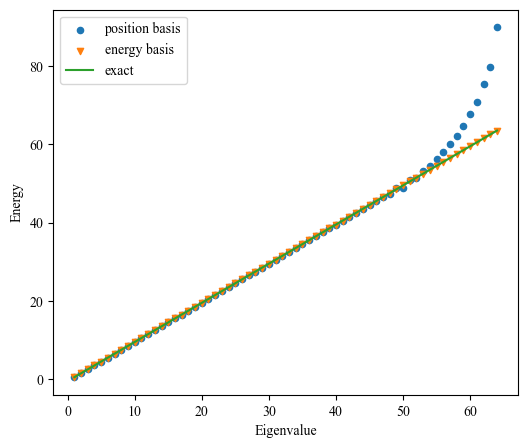

In [3]:
compareSpect(64)

In [4]:
def h2zixy(ham):
    """Decompose square real symmetric matrix into Pauli spin matrices 
    
    Parameters:
    ham (array) - a square numpy real symmetric numpy array
    
    Returns:
    a dictionary of Pauli string keys with weights as values
    """

    # weights smaller than eps are taken to be zero
    eps = 1.e-5
    
    dim = len(ham)
    
    # Step 1: expand Hamiltonian to have leading dimension = power of 2 and
    # pad with zeros if necessary

    NextPowTwo = int(2**np.ceil(np.log(dim)/np.log(2)))
    if NextPowTwo != dim:
        diff = NextPowTwo - dim
        ham = np.hstack((ham, np.zeros((dim,diff))))
        dim = NextPowTwo
        ham = np.vstack((ham, np.zeros((diff,dim))))
    
    # Step 2: generate all tensor products of the appropriate length with
    # all combinations of I, X, Y, Z, excluding those with an odd number of Y
    # matrices
    
    # Pauli is a dictionary with the four basis 2x2 Pauli matrices
    Pauli = {'I' : np.array([[1,0],[0,1]]),
             'X' : np.array([[0,1],[1,0]]),
             'Y' : np.array([[0,-1j],[1j,0]]),
             'Z' : np.array([[1,0],[0,-1]])}
    NumTensorRepetitions = int(np.log(dim) / np.log(2))
    PauliKeyList = []
    KeysToDelete = []
    PauliDict = {}
    
    def PauliDictValues(l):
        # returns a generator object, such that calling again yields the next object
        yield from itertools.product(*([l] * NumTensorRepetitions))
    

    # generate list of tensor products with all combinations of Pauli
    # matrices i .e. 'III', 'IIX', 'IIY', etc.
    for x in PauliDictValues('IXYZ'):
        PauliKeyList.append(''.join(x))
    
    for y in PauliKeyList:
        PauliDict[y] = 0
        
    for key in PauliDict:
        TempList = []
        PauliTensors = []
        NumYs = key.count('Y')
        TempKey = str(key)
    
        if (NumYs % 2) == 0:
            for string in TempKey:
                TempList.append(string)
            
            for SpinMatrix in TempList:
                PauliTensors.append(Pauli[SpinMatrix])
            
            PauliDict[key] = PauliTensors
            CurrentMatrix = PauliDict[key].copy()

            # compute tensor product between I , X , Y , Z matrices
            for k in range(1, NumTensorRepetitions):
                TemporaryDict = np.kron(CurrentMatrix[k-1], CurrentMatrix[k])
                CurrentMatrix[k] = TemporaryDict
        
            PauliDict[key] = CurrentMatrix[-1]
        
        else:
            KeysToDelete.append(key)
    
    for val in KeysToDelete:
        PauliDict.pop(val)
    
    # Step 3: loop through all the elements of the Hamiltonian matrix
    # and identify which Pauli matrix combinations contribute;
    # generate a matrix of simultaneous equations that need to be solved;
    # N.B. upper triangle of hamiltonian array is used  

    VecHamElements = np.zeros(int((dim**2 + dim) / 2))
    h=0
    for i in range(0,dim):
        for j in range(i,dim):
            arr = []
            VecHamElements[h] = ham[i,j]
            for key in PauliDict:
                TempVar = PauliDict[key]
                arr.append(TempVar[i,j].real)
            if i == 0 and j == 0:
                FinalMat = np.array(arr.copy())
            else:
                FinalMat = np.vstack((FinalMat,arr))
            
            h += 1
    
    # Step 4: use numpy.linalg.solve to solve the simultaneous equations
    # and return the weights of the Pauli strings

    x = np.linalg.solve(FinalMat,VecHamElements)
    var_list = list(PauliDict.keys())
    
    # return final Pauli decomposition of the Hamiltonian
    decHam = {}
    for i in range(len(PauliDict)):
        if abs(x[i])>eps:
            decHam[str(var_list[i])] = np.round(x[i],4)
            
    return decHam

In [5]:
print("4x4 Energy Basis Hamiltonian: ", h2zixy(QHO(4,"en")))
print("4x4 Position Basis Hamiltonian: ", h2zixy(QHO(4,"pos")))

4x4 Energy Basis Hamiltonian:  {'II': 2.0, 'IZ': 0.5, 'ZZ': -1.0}
4x4 Position Basis Hamiltonian:  {'II': 1.9635, 'IX': -0.5554, 'YY': -0.5554, 'ZZ': 0.7854}


C:\Users\johns\AppData\Local\Temp\ipykernel_15844\2746396555.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  VecHamElements[h] = ham[i,j]


In [3]:
def Measurement(quantumcircuit, **kwargs):
    """Executes measurements of a QuantumCircuit object 
    
    Parameters:
    quantumcircuit (object) - a QuantumCircuit object to be measured
    
    Keyword Arguments:
    shots (integer) - number of trials to execute for the measurement(s)
    return_M (Bool) - indicates whether to return dictionary of measurement
        results
    print_M (Bool) - indicates whether to print measurement (flipped) results
    column (Bool) - indicates whether to print measurement (flipped) results
        in a vertical column
    """

    # default kwargs
    p_M = True
    Shots=1
    ret = False
    NL = False
    if 'shots' in kwargs:
        Shots = int(kwargs['shots'])
    if 'return_M' in kwargs:
        ret = kwargs['return_M']
    if 'print_M' in kwargs:
        p_M = kwargs['print_M']
    if 'column' in kwargs:
        NL = kwargs['column']
    M1 = execute(quantumcircuit, BasicAer.get_backend('qasm_simulator'),
                 shots=Shots).result().get_counts(quantumcircuit)
    M2 = {}
    k1 = list(M1.keys())
    v1 = list(M1.values())
    for k in np.arange(len(k1)):
        key_list = list(k1[k])
        new_key = ''
        for j in np.arange(len(key_list)):
            new_key = new_key+key_list[len(key_list)-(j+1)]
        M2[new_key] = v1[k]
    if(p_M):
        k2 = list(M2.keys())
        v2 = list(M2.values())
        measurements = ''
        for i in np.arange( len(k2) ):
            m_str = str(v2[i])+'|'
            for j in np.arange(len(k2[i])): 
                if( k2[i][j] == '0' ):
                    m_str = m_str+'0'
                if( k2[i][j] == '1' ):
                    m_str = m_str+'1'
                if( k2[i][j] == ' ' ):
                    m_str = m_str+'>|'
            m_str = m_str+'> '
            if(NL):
                m_str = m_str + '\n'
            measurements = measurements + m_str
        print(measurements)
    if(ret):
        return M2   
    
def Two_Qubit_HEA(qc, params):
    """Applies rotation and entangling gates for a 2-qubit HEA state

    Parameters:
    qc (QuantumCircuit) - the quantum circuit to be measured
    params (array) - contains 8 parameters for current iteration
    """

    qc.ry(params[0], 0)
    qc.rz(params[1], 0)
    qc.ry(params[2], 1)
    qc.rz(params[3], 1)
    qc.cx(0,1)
    qc.ry(params[4], 0)
    qc.rz(params[5], 0)
    qc.ry(params[6], 1)
    qc.rz(params[7], 1)

def Two_Qubit_UniversalAnsatz(qc, params):
    """Applies rotation and entangling gates for a universal 2-qubit ansatz
        state

    Parameters:
    qc (QuantumCircuit) - the quantum circuit to be measured
    params (array) - contains 16 parameters for current iteration
    """

    qc.ry(params[0], 0)
    qc.rz(params[1], 0)
    qc.ry(params[2], 1)
    qc.rz(params[3], 1)
    qc.cx(0,1)
    qc.ry(params[4], 0)
    qc.rz(params[5], 0)
    qc.ry(params[6], 1)
    qc.rz(params[7], 1)
    qc.cx(1,0)
    qc.ry(params[8], 0)
    qc.rz(params[9], 0)
    qc.ry(params[10], 1)
    qc.rz(params[11], 1)
    qc.cx(0,1)
    qc.ry(params[12], 0)
    qc.rz(params[13], 0)
    qc.ry(params[14], 1)
    qc.rz(params[15], 1)
    
def Four_Qubit_HEA(qc, params):
    """Applies rotation and entangling gates for a universal 2-qubit ansatz
        state

    Parameters:
    qc (QuantumCircuit) - the quantum circuit to be measured
    params (array) - contains 16 parameters for current iteration
    """
    qc.ry(params[0], 0)
    qc.rx(params[1], 1)
    qc.ry(params[2], 2)
    qc.rx(params[3], 3)
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    qc.barrier()
    qc.ry(params[4], 0)
    qc.rx(params[5], 1)
    qc.ry(params[6], 2)
    qc.rx(params[7], 3)
    qc.cx(1,0)
    qc.cx(2,3)
    qc.cx(1,2)
    qc.barrier()
    qc.ry(params[8], 0)
    qc.rx(params[9], 1)
    qc.ry(params[10], 2)
    qc.rx(params[11], 3)
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    qc.barrier()
    qc.ry(params[12], 0)
    qc.rx(params[13], 1)
    qc.ry(params[14], 2)
    qc.rx(params[15], 3)

def VQE_EV(params, Ansatz, H, **kwargs):
    """Computes and returns the expectation value of a Hamiltonian
        for some parametrized ansatz

    Parameters:
    params (array) - parameters for ansatz
    Ansatz (object) - type of ansatz to be used for measurement
    H (dictionary) - Pauli strings as keys and weights as values
    Keyword Arguments:
    shots (integer) - number of measurements to use per computation
    """

    Shots = 1000
    if 'shots' in kwargs:
        Shots = int(kwargs['shots'])
    Hk = list( H.keys() )
    H_EV = 0
    for k in np.arange( len(Hk) ):
        L = list( Hk[k] )
        q = QuantumRegister(len(L))
        c = ClassicalRegister(len(L))
        qc = QuantumCircuit(q,c)
        Ansatz( qc, params )
        for l in np.arange( len(L) ):
            if( L[l] == 'X' ):
                qc.ry(-np.pi/2,q[int(l)])
                qc.measure(int(l),int(l))
            if( L[l] == 'Y' ):
                qc.rx( np.pi/2,q[int(l)])
                qc.measure(int(l),int(l))
            if( L[l] == 'Z' ):
                qc.measure(int(l),int(l))
        M = Measurement( qc, shots=Shots, print_M=False, return_M=True )
        Mk = list( M.keys() )
        H_ev = 0
        for m1 in np.arange(len(Mk)):
            MS = list( Mk[m1] )
            e = 1
            for m2 in np.arange(len(MS)):
                if( MS[m2] == '1'):
                    e = e*(-1)
            H_ev = H_ev + e * M[Mk[m1]]
        H_EV = H_EV + H[Hk[k]]*H_ev/Shots
    return H_EV

def Nelder_Mead(H, Ansatz, Vert, Val):
    """Computes and appends values for the next step in the Nelder-Mead
        optimization algorithm

    Parameters:
    H (dictionary) - Pauli strings as keys and weights as values
    Ansatz (function) - chosen ansatz to measure Pauli strings
    Vert (array) - contains vertices forming the simplex
    Val (array) - contains measurements over each vertex
    """
    alpha = 2
    gamma = 2
    rho   = 0.5
    sigma = 0.5
    add_reflect = False
    add_expand = False
    add_contract = False
    shrink = False
    add_bool = False
#----------------------------------------
    # gets value / index of largest point
    hi = Calculate_MinMax( Val,'max' )
    # gets value / index of all points not the largest
    Vert2 = []
    Val2 = []
    for i in np.arange(len(Val)):
        if( int(i) != hi[1] ):
            Vert2.append( Vert[i] )
            Val2.append( Val[i] )
    Center_P = Compute_Centroid(Vert2)
    Reflect_P = Reflection_Point(Vert[hi[1]],Center_P,alpha)
    #gets expectation value at Reflection Point
    Reflect_V = VQE_EV(Reflect_P,Ansatz,H)
#------------------------------------------------- 
# determine if: reflect / expand / contract / shrink
    hi2 = Calculate_MinMax( Val2,'max' ) # worst
    lo2 = Calculate_MinMax( Val2,'min' ) # best
    if( hi2[0] > Reflect_V >= lo2[0] ):
        add_reflect = True
    elif( Reflect_V < lo2[0] ):
        Expand_P = Reflection_Point(Center_P,Reflect_P,gamma)
        Expand_V = VQE_EV(Expand_P,Ansatz,H)
        if( Expand_V < Reflect_V ):
            add_expand = True
        else:
            add_reflect = True
    elif( Reflect_V > hi2[0] ):
        if( Reflect_V < hi[0] ):
            Contract_P = Reflection_Point(Center_P,Reflect_P,rho)
            Contract_V = VQE_EV(Contract_P,Ansatz,H)
            if( Contract_V < Reflect_V ):
                add_contract = True
            else:
                shrink = True
        else:
            Contract_P = Reflection_Point(Center_P,Vert[hi[1]],rho)
            Contract_V = VQE_EV(Contract_P,Ansatz,H)
            if( Contract_V < Val[hi[1]] ):
                add_contract = True
            else:
                shrink = True
#-------------------------------------------------
 # apply: reflect / expand / contract / shrink
    if( add_reflect == True ):
        new_P = Reflect_P
        new_V = Reflect_V
        add_bool = True
    elif( add_expand == True ):
        new_P = Expand_P
        new_V = Expand_V
        add_bool = True
    elif( add_contract == True ):
        new_P = Contract_P
        new_V = Contract_V
        add_bool = True
    if( add_bool ):
        del Vert[hi[1]]
        del Val[hi[1]]
        Vert.append( new_P )
        Val.append( new_V )
    if( shrink ):
        Vert3 = []
        Val3 = []
        lo = Calculate_MinMax( Val,'min' )
        Vert3.append( Vert[lo[1]] )
        Val3.append( Val[lo[1]] )
        for j in np.arange( len(Val) ):
            if( int(j) != lo[1] ):
                Shrink_P = Reflection_Point(Vert[lo[1]],Vert[j],sigma)
                Vert3.append( Shrink_P )
                Val3.append( VQE_EV(Shrink_P,Ansatz,H) )
        for j2 in np.arange( len(Val) ):
            del Vert[0]
            del Val[0]
            Vert.append( Vert3[j2] )
            Val.append( Val3[j2] )

def Calculate_MinMax(V, C_type):
    """Returns the smallest or biggest value / index in an array"""
    if( C_type == 'min' ):
        lowest = [V[0],0]
        for i in np.arange(1,len(V)):
            if( V[i] < lowest[0] ):
                lowest[0] = V[i]
                lowest[1] = int(i)
        return lowest
    if( C_type == 'max' ):
        highest = [V[0],0]
        for i in np.arange(1,len(V)):
            if( V[i] > highest[0] ):
                highest[0] = V[i]
                highest[1] = int(i)
        return highest
            
def Compute_Centroid(V):
    """Returns the centroid from a given array of values"""
    points = len( V ) # no. of points
    dim = len( V[0] ) # dimension of parameter space
    Cent = []

    for d in np.arange( dim ):
        avg = 0
        for a in np.arange( points ):
            avg = avg + V[a][d]/points
        Cent.append( avg )
    return Cent

def Reflection_Point(P1, P2, alpha):
    """Computes a reflection point from P1 around P2 by an amount alpha"""
    P = []
    for p in np.arange( len(P1) ):
        D = P2[p] - P1[p]
        P.append( P1[p]+alpha*D )
    return P

def runVQE(H, myAnsatz):
    """Performs a single run of the VQE algorithm over input Hamiltonian
        and chosen ansatz

    Parameters:
    H (dictionary) -  Pauli strings as keys and weights as values
    myAnsatz (function) - Hamiltonian is measured with respect to
        chosen ansatz

    Returns:
    list containing a list of lowest values in each iteration and 
        the total run time
    """
    if myAnsatz == Two_Qubit_HEA:
        paramdim = 8
    elif (myAnsatz == Two_Qubit_UniversalAnsatz) or (myAnsatz == Four_Qubit_HEA):
        paramdim = 16

    start_time = time.time()
    lowestvals = []
    P = []
    for p in np.arange(paramdim/2):
        P.append( random.random()*np.pi )
        P.append( random.random()*2*np.pi )
    delta = 0.001
    #------------------------------
    Vertices = []
    Values = []
    # generate initial set of vertices and values
    for v1 in np.arange(len(P)+1):
        V = [] 
        # generates initial set of vertices
        for v2 in np.arange(len(P)):
            # radius ensures points are relatively grouped together;
            # small coordinate perturbations
            R = round((0.4+random.random()*0.8)*(-1)**(round(random.random())),5)
            V.append( P[v2]+R )
        Vertices.append( V )
        # generates initial set of values
        Values.append( VQE_EV(V, myAnsatz, H) )
    #------------------------------
    terminate = False
    iters = 0
    terminate_count = 0
    terminate_limit = 50
    while( (terminate==False) ):
        iters = iters + 1
        low = Calculate_MinMax( Values,'min' )
        lowestvals.append(low[0])
        Nelder_Mead(H, myAnsatz, Vertices, Values)
        new_low = Calculate_MinMax( Values,'min' )
        if( abs( new_low[0] - low[0] ) < delta ):
            terminate_count += 1
        else:
            terminate_count = 0
        if( terminate_count == terminate_limit ):
            terminate = True
            print('\n_____ Nelder-Mead Complete _____\n')
            print(' --------------------- \n Iteration: ',iters,'Lowest EV: ',round( low[0],6 ))
        if( ( (iters==1) or (iters%10==0) ) and (terminate==False) ):
            print('Iteration: ',iters,' Lowest EV: ',round( low[0],6 ))
    
    run_time = time.time() - start_time
    return [lowestvals,run_time]

In [7]:
def multiRuns(runs, H, ansatz, fname):
    """Performs multiple VQE runs and saves list of lowest values and
        run times for each run to a csv file
    
    Parameters:
    runs (int) - number of runs
    H (dictionary) - Pauli strings as keys and weights as values
    ansatz (function) - Hamiltonian is measured with respect to chosen ansatz
    fname (string) - file name for csv file
    """
    multires = []
    if ansatz == Two_Qubit_HEA or ansatz == Two_Qubit_UniversalAnsatz:
        save = H["II"]
        del(H["II"])
    elif ansatz == Four_Qubit_HEA:
        save = H["IIII"]
        del(H["IIII"])
    for i in range(runs):
        print("\n_____Multi-Run: Iteration "+str(i+1)+"_____\n")
        results = runVQE(H,ansatz)
        multires.append([results[0] + save,results[1]])
    lowvals = [i[0] for i in multires]
    runtimes = [i[1] for i in multires]
    dict = {'Lowest Values':lowvals, 'Run Times (s)':runtimes}
    df = pd.DataFrame(dict)
    df.to_csv(fname+'.csv')

    return multires

def unliRuns(H, ansatz, fname):
    """Performs multiple VQE runs until convergence and saves list of
        lowest values and run times for each run to a csv file
    
    Parameters:
    H (dictionary) - Pauli strings as keys and weights as values
    ansatz (function) - Hamiltonian is measured with respect to chosen ansatz
    fname (string) - file name for csv file
    """
    converged = False
    unlires = []
    iters = 0
    if ansatz == Two_Qubit_HEA or ansatz == Two_Qubit_UniversalAnsatz:
        save = H["II"]
        del(H["II"])
    elif ansatz == Four_Qubit_HEA:
        save = H["IIII"]
        del(H["IIII"])
    while converged == False:
        iters += 1
        print("\n_____Unli-Run: Iteration "+str(iters)+"_____\n")
        results = runVQE(H,ansatz)
        test = results[0] + save
        if(test[-1] <= 0.51): # 0.51 for less tolerance
            converged = True
        unlires.append([test,results[1]])
        print(test[-1])
        
    lowvals = [i[0] for i in unlires]
    runtimes = [i[1] for i in unlires]
    dict = {'Lowest Values':lowvals, 'Run Times (s)':runtimes}
    df = pd.DataFrame(dict)
    df.to_csv(fname+'.csv')

    return unlires

multiRuns(30,h2zixy(QHO(4,"pos")),Two_Qubit_HEA,"genData/2QHEAPosBasis")
multiRuns(30,h2zixy(QHO(4,"pos")),Two_Qubit_UniversalAnsatz,"genData/2QUAPosBasis")
multiRuns(30,h2zixy(QHO(16,"pos")),Four_Qubit_HEA,"genData/4QHEAPosBasis")

multiRuns(30,h2zixy(QHO(4,"en")),Two_Qubit_HEA,"genData/2QHEAEnBasis")
multiRuns(30,h2zixy(QHO(4,"en")),Two_Qubit_UniversalAnsatz,"genData/2QUAEnBasis")
multiRuns(30,h2zixy(QHO(16,"en")),Four_Qubit_HEA,"genData/4QHEAEnBasis")
unliRuns(h2zixy(QHO(16,'en')), Four_Qubit_HEA,"genData/4QHEAEnBasis_unliruns")

C:\Users\johns\anaconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


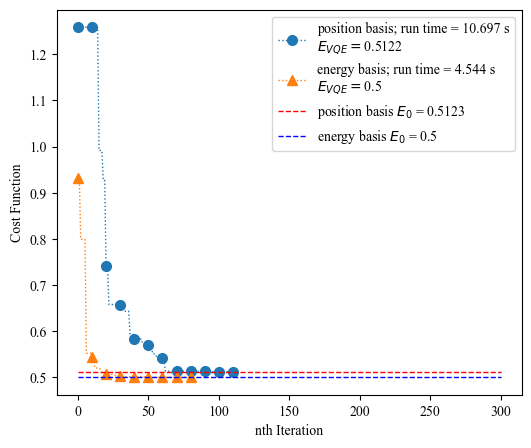

C:\Users\johns\anaconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


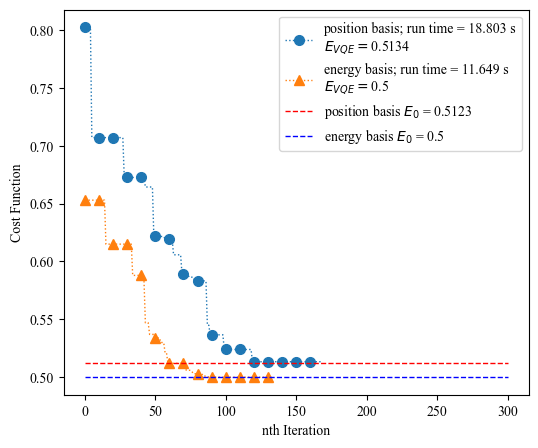

C:\Users\johns\anaconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


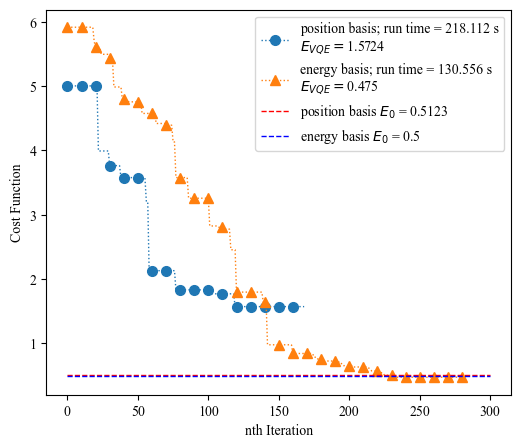

In [9]:
def shortList(path, msize, basis):
    """Grab a short list of accurate ground states"""
    vals, vecs = np.linalg.eig(QHO(msize,basis))
    exact = np.sort(vals)[0]
    
    df = pd.read_csv(path)
    header1 = df.columns.values[1]
    header2 = df.columns.values[2]

    acc = 50
    for i in range(len(df[header1])):
        removebracks = df[header1][i].replace("[","").replace("]","")
        mylist = removebracks.split()
        numlist = [float(i) for i in mylist]
        run_time = float(df[header2][i])

        if abs(numlist[-1] - exact) < acc:
            acc = abs(numlist[-1] - exact)
            slvals = []
            sltimes = []
            slvals.append(numlist)
            sltimes.append(run_time)
        elif abs(numlist[-1] - exact) == acc:
            slvals.append(numlist)
            sltimes.append(run_time)
    return slvals, sltimes, exact

def graphComp(path_en,path_pos,msize,imgpath):
    """Graph most accurate run with shortest no. of iterations"""
    
    slvalsen, sltimesen, exacten = shortList(path_en,4,"en")
    slvalspos, sltimespos, exactpos = shortList(path_pos,4,"pos")
    maxlen = 300
    for i in range(len(slvalsen)):
        if len(slvalsen[i]) < maxlen:
            tographen = []
            maxlen = len(slvalsen[i])
            tographen.append(slvalsen[i])
            tographen.append(sltimesen[i])
    maxlen = 300
    for i in range(len(slvalspos)):
        if len(slvalspos[i]) < maxlen:
            tographpos = []
            maxlen = len(slvalspos[i])
            tographpos.append(slvalspos[i])
            tographpos.append(sltimespos[i])
    
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    ax.plot(range(0,len(tographpos[0])),tographpos[0],marker="o", markersize = 7,
            markevery=10, linewidth = 1, linestyle = 'dotted')
    ax.plot(range(0,len(tographen[0])),tographen[0],marker="^", markersize = 7,
            markevery=10, linewidth = 1, linestyle = 'dotted')
    ax.plot((0,300),(exactpos,exactpos),color='red', linewidth = 1,
            linestyle="dashed")
    ax.plot((0,300),(exacten,exacten),color='blue', linewidth = 1,
            linestyle="dashed")
    ax.set_ylabel("Cost Function")
    ax.set_xlabel("nth Iteration")
    ax.legend(["position basis; run time = "+str(round(tographpos[1],3)) 
               + " s\n" r"$E_{VQE} = $" + str(np.round(tographpos[0][-1],4)),
               "energy basis; run time = "+str(round(tographen[1],3)) 
               + " s\n" r"$E_{VQE} = $" + str(np.round(tographen[0][-1],4)),
               "position basis "+ r"$E_0$ = "+str(np.real(np.round(exactpos,4))),
               "energy basis " + r"$E_0$ = "+str(exacten)],loc='best')
    plt.savefig(imgpath, dpi=600)
    plt.show()
            

def countConv(path, basis):
    """Count number of minimized runs to check for consistency"""
    if basis == 'en':
        conv = 0.5
    elif basis == 'pos':
        conv = 0.52 #more tolerance

    df = pd.read_csv(path)
    header1 = df.columns.values[1]

    count = 0
    count_anoms = 0
    for i in range(len(df[header1])):
        removebracks = df[header1][i].replace("[","").replace("]","")
        mylist = removebracks.split()
        numlist = [float(i) for i in mylist]
        
        if np.sort(numlist)[0] <= conv:
            count += 1
        if len(numlist) == 200:
            count_anoms += 1
    print(count_anoms)
    return count

# Generating graphs
mypathen1 = "genData/2QHEAEnBasis.csv"
mypathpos1 = "genData/2QHEAPosBasis.csv"
imgpath1  ="genFigs/2QHEA.png"
graphComp(mypathen1,mypathpos1,4,imgpath1)

mypathen2 = "genData/2QUAEnBasis.csv"
mypathpos2 = "genData/2QUAPosBasis.csv"
imgpath2  ="genFigs/2QUA.png"
graphComp(mypathen2,mypathpos2,4,imgpath2)

mypathen3 = "genData/4QHEAEnBasis.csv"
mypathpos3 = "genData/4QHEAPosBasis.csv"
imgpath3  ="genFigs/4QHEA.png"
graphComp(mypathen3,mypathpos3,4,imgpath3)

In [4]:
# Generating circuit images
Two_QHEACirc = QuantumCircuit(2,2)
Two_Qubit_HEA(Two_QHEACirc, [Parameter(r"$\theta$"+str(i)) for i in range(8)])
Two_QUACirc = QuantumCircuit(2,2)
Two_Qubit_UniversalAnsatz(Two_QUACirc, [Parameter(r"$\theta$"+str(i)) for i in range(16)])
Four_QHEACirc = QuantumCircuit(4,4)
Four_Qubit_HEA(Four_QHEACirc, [Parameter(r"$\theta$"+str(i)) for i in range(16)])

Two_QHEACirc.draw('mpl').savefig("genFigs/2QHEACirc.png", dpi = 600)
Two_QUACirc.draw('mpl').savefig("genFigs/U2QACirc.png", dpi = 600)
Four_QHEACirc.draw('mpl').savefig("genFigs/4QHEACirc.png", dpi = 600)

# Example circuit for HEA
qc = QuantumCircuit(2,2)
params = [Parameter(r"$\theta$"+str(i)) for i in range(16)]
qc.ry(params[0], 0)
qc.rz(params[1], 0)
qc.ry(params[2], 1)
qc.rz(params[3], 1)
qc.cx(0,1)
qc.ry(params[4], 0)
qc.rz(params[5], 0)
qc.ry(params[6], 1)
qc.rz(params[7], 1)
qc.cx(0,1)
qc.ry(params[8], 0)
qc.rz(params[9], 0)
qc.ry(params[10], 1)
qc.rz(params[11], 1)
qc.cx(0,1)
qc.ry(params[12], 0)
qc.rz(params[13], 0)
qc.ry(params[14], 1)
qc.rz(params[15], 1)
qc.draw('mpl').savefig("genFigs/2QHEA_3ent.png", dpi = 600)

C:\Users\johns\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)
